In [1]:
import os

import pandas as pd
from sqlalchemy import create_engine

import openmimic as om

# db configuration
username = 'root'
password = os.getenv('AIMED_PW')
host = '172.28.8.103'
port = '3306'
database = "MIMIC_III"
db_engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# om configuration
om.Config.mimic_path = "../mimic3_csv/"

# path configuration
processed_tables_path = "./processed_data/"

In [6]:
import importlib


def reload_all():
    importlib.reload(om)
    importlib.reload(om.chartevents)
    importlib.reload(om.chartevents_engineering)
    # importlib.reload(om.cohort)
    importlib.reload(om.config)
    importlib.reload(om.utils)
    importlib.reload(om.inputevents_mv)
    importlib.reload(om.inputevents_mv_engineering)
    importlib.reload(om.mimic_preprocessor)
    importlib.reload(om.patient_static)
    importlib.reload(om.patient_static_engineering)
    importlib.reload(om.outputevents)
    importlib.reload(om.outputevents_engineering)
    importlib.reload(om.labevents)
    importlib.reload(om.labevents_engineering)


reload_all()

# Patient_static

In [2]:
# query = "SELECT * FROM patient_static"
# patients_all = pd.read_sql(query, db_engine)
patients_static_csv = pd.read_csv(processed_tables_path + "patients_static.csv")
patients_static_T_info_csv = pd.read_csv(processed_tables_path + "patients_static_T_info.csv")

patients_static = om.PatientStatic()
patients_static.load_processed(patients_static_csv, patients_static_T_info_csv)
# patients_static.load(patients_all)
# patients_static.patients_T_info

# Chartevents

In [12]:
chartevents_items = (
    769, 220644, 772, 1521, 227456, 773, 225612, 227073, 770, 220587, 227443, 848, 225690, 1538, 225651, 803, 781, 1162,
    225624, 225625, 786, 1522, 816, 225667, 116, 89, 90, 220074, 113, 220602, 226536, 1523, 788, 789, 1524, 220603, 787,
    857, 225698, 777, 223679, 791, 1525, 220615, 224643, 225310, 220180, 8555, 220051, 8368, 8441, 8440, 227468, 1528,
    806,
    189, 727, 223835, 190, 198, 220621, 225664, 811, 807, 226537, 1529, 211, 220045, 226707, 226730, 1394, 813, 220545,
    220228, 814, 818, 225668, 1531, 220635, 1532, 821, 456, 220181, 224, 225312, 220052, 52, 6702, 224322, 646, 834,
    220277,
    220227, 226062, 778, 220235, 779, 227466, 825, 1533, 535, 224695, 860, 223830, 1126, 780, 220274, 1534, 225677, 827,
    224696, 543, 828, 227457, 224700, 506, 220339, 512, 829, 1535, 227464, 227442, 227467, 1530, 815, 1286, 824, 227465,
    491, 492, 220059, 504, 833, 224422, 618, 220210, 224689, 614, 651, 224690, 615, 224688, 619, 837, 1536, 220645,
    226534,
    626, 442, 227243, 224167, 220179, 225309, 6701, 220050, 51, 455, 223761, 677, 676, 679, 678, 223762, 224685, 682,
    224684, 683, 684, 224686, 1539, 849, 851, 227429, 859, 226531, 763, 224639, 226512, 861, 1542, 220546, 1127)
query = f"SELECT * FROM CHARTEVENTS WHERE ITEMID IN {chartevents_items} ORDER BY CHARTTIME;"
chartevents_raw = pd.read_sql(query, db_engine)

In [3]:
chartevents_raw = pd.read_csv(processed_tables_path + "raw_chartevents.csv")
chartevents_raw["CHARTTIME"] = pd.to_datetime(chartevents_raw["CHARTTIME"])
chartevents_raw["ICUSTAY_ID"].unique()

KeyboardInterrupt: 

In [4]:
chartevents = om.Chartevents()
chartevents.load(chartevents_raw, patients_static.patients_T_info)
chartevents.process()

../mimic3_csv/
Chartevents data updated!
-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	1.20s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	2.33s
-> filter_remove_error...	 Complete!	1.82s
-> filter_remove_labitems...	../mimic3_csv/
 Complete!	1.25s
Chartevents data updated!
=> Before: 66,635,422, After: 66,534,355 : 99.85% remained.
Filtering Complete!
-----------------------------------
Processing...
-> process_group_variables_from_fiddle...	 Complete!	20.60s
Chartevents data updated!
-> process_aggregator...	 Complete!	6m 25.68s
-> process_interval_shift_alignment...	 Complete!	4.50s
Processing Complete!


# Inputevents_MV

In [4]:
columns = "ROW_ID, ICUSTAY_ID, STARTTIME, ENDTIME, ITEMID, AMOUNT, AMOUNTUOM, RATE, RATEUOM, PATIENTWEIGHT"
columns = "*"
query = f"SELECT {columns} FROM INPUTEVENTS_MV"
inputevents_mv_raw = pd.read_sql(query, db_engine)

In [5]:
inputevents_mv = om.InputeventsMV()
inputevents_mv.load(inputevents_mv_raw, patients_static.patients_T_info)
inputevents_mv.process()

-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	0.26s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	0.34s
-> filter_remove_error...	 Complete!	0.63s
-> filter_remove_zero_input...	 Complete!	0.58s
-> filter_remove_continuous_uom_missing...	 Complete!	0.69s
=> Before: 3,618,991, After: 2,535,497 : 70.06% remained.
Filtering Complete!
-----------------------------------
Processing...
-> process_rateuom_into_hour_unit...	 Complete!	3.02s
-> process_unite_convertable_uom_by_D_ITEMS...	 Complete!	4.57s
-> process_split_ITEMID_by_unit...	 Complete!	3.49s
-> process_transform_T_cohort...	 Complete!	4m 8.95s
Processing Complete!


# Outputevents

In [7]:
columns = "*"
query = f"SELECT {columns} FROM OUTPUTEVENTS"
outputevents_raw = pd.read_sql(query, db_engine)

In [8]:
outputevents = om.Outputevents()
outputevents.load(outputevents_raw, patients_static.patients_T_info)
outputevents.process()

-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	0.08s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	0.14s
-> filter_remove_error...	 Complete!	0.07s
-> filter_remove_zero_value...	 Complete!	0.11s
Outputevents data updated!
Filtering Complete!
=> Before: 4,349,218, After: 4,046,702 : 93.04% remained.
-----------------------------------
Processing...
-> process_aggregator...	 Complete!	2m 19.78s
-> process_interval_shift_alignment...	 Complete!	17.39s
Processing Complete!


# Labevents

In [3]:
columns = "*"
query = f"SELECT {columns} FROM LABEVENTS"
labevents_raw = pd.read_sql(query, db_engine)

In [4]:
query = f"SELECT * FROM ICUSTAYS"
icustay_raw = pd.read_sql(query, db_engine)

In [5]:
labevents = om.Labevents()
labevents.load(labevents_raw, patients_static.patients_T_info)
labevents.attach_icustay_id(icustay_raw)
labevents.filter()
labevents.process()

ICUSTAY_ID attached
-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	0.74s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	1.10s
-> filter_remove_non_numeric_value...	

/home/jgpark/PycharmProjects/MIMIC_preprocessing/openmimic/labevents_engineering.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labevents["VALUE"] = labevents["VALUE"].astype(float)


 Complete!	6.95s
=> Before: 32,331,081, After: 24,066,566 : 74.44% remained.
Filtering Complete!
-----------------------------------
Processing...
-> process_aggregator...	 Complete!	2m 16.38s
Processing Complete!


# Cohort Integration


In [3]:
patients_static_csv = pd.read_csv(processed_tables_path + "p_patients_static.csv")
patients_static_T_info_csv = pd.read_csv(processed_tables_path + "p_patients_static_T_info.csv")
chartevents = pd.read_csv(processed_tables_path + "p_chartevents.csv")
inputevents_mv = pd.read_csv(processed_tables_path + "p_inputevents_mv.csv")
outputevents = pd.read_csv(processed_tables_path + "p_outputevents.csv")
labevents = pd.read_csv(processed_tables_path + "p_labevents.csv")

patients_static = om.PatientStatic()
patients_static.load_processed(patients_static_csv, patients_static_T_info_csv)
chartevents = om.Chartevents().load_processed(chartevents)
inputevents_mv = om.InputeventsMV().load_processed(inputevents_mv)
outputevents = om.Outputevents().load_processed(outputevents)
labevents = om.Labevents().load_processed(labevents, patients_static.patients_T_info)


KeyboardInterrupt



In [11]:
cohort = om.Cohort(patients_static, chartevents, inputevents_mv)
cohort.make_cohort()
cohort.data.sort_values(by=["ICUSTAY_ID", "T"])

In [26]:
features, label = cohort.make_train_set()
# features.to_csv(processed_data_path+"mimic_features.csv")
# label.to_csv(processed_data_path+"mimic_label.csv")

In [11]:
df = pd.read_csv(processed_tables_path + "cohort.csv", index_col=0)
cohort = om.Cohort(cohort=df)

/tmp/ipykernel_2501554/2820402200.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(processed_data_path+"cohort.csv", index_col=0)


In [12]:
cohort.data

,SUBJECT_ID,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,ICUSTAY_ID,LOS,FIRST_CAREUNIT,FIRST_WARDID,HADM_to_ICU_time,...,Replete (2/3) (0),Imipenem/Cilastatin (1),Boost Glucose Control (3/4) (0),Resource Fruit Beverage (0),Mighty Shake (no sugar added) (0),Nutren 2.0 (3/4) (0),Keflex (1),Quinine (0),Lansoprazole (Prevacid) (1),label
0,2,0.0000,M,NEWBORN,PHYS REFERRAL/NORMAL DELI,243653,0.0918,NICU,56,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,0.0000,M,NEWBORN,PHYS REFERRAL/NORMAL DELI,243653,0.0918,NICU,56,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,76.5753,M,EMERGENCY,EMERGENCY ROOM ADMIT,211552,6.0646,MICU,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,76.5753,M,EMERGENCY,EMERGENCY ROOM ADMIT,211552,6.0646,MICU,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3,76.5753,M,EMERGENCY,EMERGENCY ROOM ADMIT,211552,6.0646,MICU,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239467,99999,64.0247,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,246512,1.1242,SICU,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239468,99999,64.0247,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,246512,1.1242,SICU,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239469,99999,64.0247,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,246512,1.1242,SICU,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239470,99999,64.0247,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,246512,1.1242,SICU,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [14]:
cohort.data[(cohort.data["T"] >= 47) & (cohort.data["AGE"] >= 18)]

,SUBJECT_ID,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,ICUSTAY_ID,LOS,FIRST_CAREUNIT,FIRST_WARDID,HADM_to_ICU_time,...,Replete (2/3) (0),Imipenem/Cilastatin (1),Boost Glucose Control (3/4) (0),Resource Fruit Beverage (0),Mighty Shake (no sugar added) (0),Nutren 2.0 (3/4) (0),Keflex (1),Quinine (0),Lansoprazole (Prevacid) (1),label
49,3,76.5753,M,EMERGENCY,EMERGENCY ROOM ADMIT,211552,6.0646,MICU,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
137,6,65.9836,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,228232,3.6729,SICU,33,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
214,9,41.8164,M,EMERGENCY,EMERGENCY ROOM ADMIT,220597,5.3231,MICU,15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
348,12,72.4219,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,232669,7.6348,SICU,23,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
396,13,39.8904,F,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,263738,3.6660,CCU,57,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239181,99982,65.3068,M,EMERGENCY,CLINIC REFERRAL/PREMATURE,275958,4.9427,CCU,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239229,99982,65.4192,M,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,239827,6.1701,CCU,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239302,99985,53.8493,M,EMERGENCY,EMERGENCY ROOM ADMIT,279638,11.2998,MICU,52,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239350,99991,47.7589,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,226241,3.1426,TSICU,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
id = 200001
patients_static.patients_T_info[patients_static.patients_T_info["ICUSTAY_ID"] == id]["T"].max(), \
    chartevents.data[chartevents.data["ICUSTAY_ID"] == id]["T"].max(), \
    inputevents_mv.data[inputevents_mv.data["ICUSTAY_ID"] == id]["T"].max(), \
    outputevents.data[outputevents.data["ICUSTAY_ID"] == id]["T"].max()

(47, 45.0, 44, 26)

In [ ]:
target = inputevents_mv.data
target[target["ICUSTAY_ID"] == 200001]

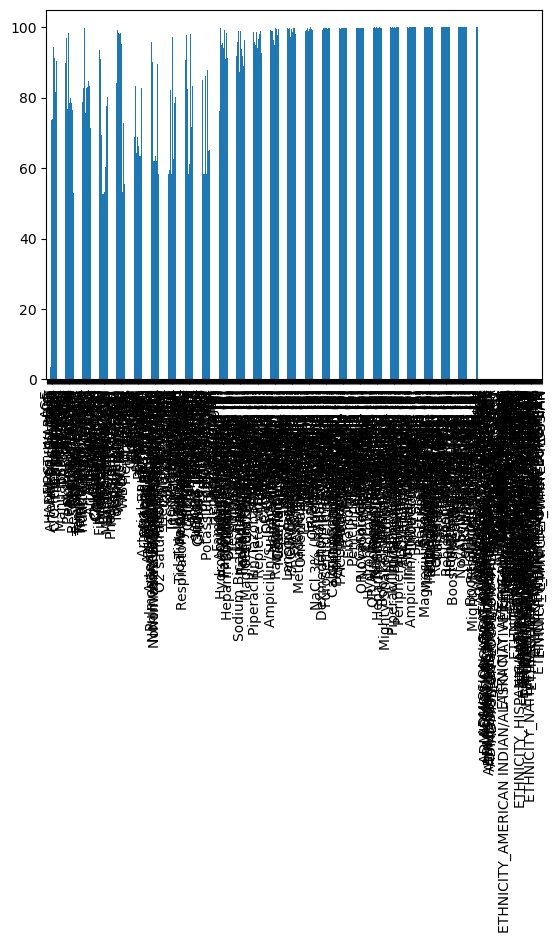

In [19]:
import matplotlib.pyplot as plt

missing_percentage = cohort.data.groupby("ICUSTAY_ID").mean().isnull().mean() * 100

missing_percentage.plot(kind="bar")
plt.show()

# Machine Learning Task

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
features, label = rus.fit_resample(features, label)
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42, stratify=label)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict_proba(x_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.9048288627711768

In [18]:
label.value_counts()

label
0.0    6535
1.0    6535
Name: count, dtype: int64

In [19]:
y_test.value_counts()

label
0.0    1307
1.0    1307
Name: count, dtype: int64

In [24]:
"PO Intake (0)" in inputevents_mv.data.columns

True

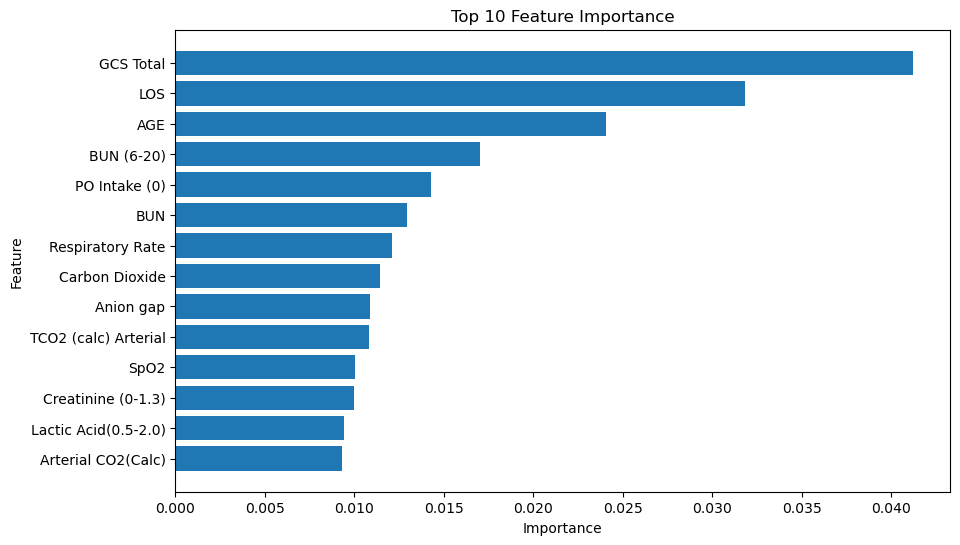

In [21]:
import matplotlib.pyplot as plt

# 피처 중요도 추출
feature_importances = model.feature_importances_

# 피처 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': feature_importances
})

# 피처 중요도 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 상위 10개 피처 선택
top_10_features = feature_importance_df.head(15)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 정렬
plt.show()